In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from IPython.display import Image

%matplotlib inline

In [27]:
stationsNames = {'A':['','San Pedrito','Plaza de Mayo'],
                'B':['','Juan Manuel de Rosas','Leandro N. Alem'],
                'C':['','Constitucion','Retiro'],
                'D':['','Congreso de Tucuman','Catedral'],
                'E':['','Plaza de los Virreyes','Bolivar'],
                'H':['','Las Heras','Hospitales'],
                'P':['','',''],}

lineColors = {'A':'dodgerblue','B':'red','C':'mediumblue','D':'forestgreen','E':'purple','H':'yellow','P':'coral'}

In [2]:
rawData = pd.read_csv('formaciones-despachadas.csv', sep = ';')
rawData.drop(['FR1_REGIST','FR1_KM','FR1_KMV'], axis = 1, inplace = True)
rawData.head()


# rename remaining columns

rawData.columns = ['date','line','dayType','travelId','trainId',
                   'notDispach1','notDispach1Details','notDispach2','notDispach2Details',
                  'amountCars1','amountCars2','dispached1','dispached2',
                  'time1','time2']

t1 = rawData.drop(['notDispach2','notDispach2Details','amountCars2','dispached2','time2'], axis = 1)
t1['terminal']=1

t2 = rawData.drop(['notDispach1','notDispach1Details','amountCars2','dispached1','time1'], axis = 1)
t2['terminal']=2

#remane columns
t1.columns = ['date','line','dayType','travelId','trainId','notDispach',
              'notDispachDetails','amountCars','dispached','time','terminal']
t2.columns = t1.columns 


# join by rows

cleanData = t1.append(t2,ignore_index=True).reindex()
cleanData.head()



# Create a depart timestamp

cleanData['depart'] = cleanData.date + ' ' + cleanData.time
cleanData.date = pd.to_datetime(cleanData.date, format='%d/%m/%Y')
cleanData.depart = pd.to_datetime(cleanData.depart, format='%d/%m/%Y %H:%M:%S')

In [3]:
cleanData.sort_values(by=['line','terminal','depart'],inplace=True)
cleanData.reset_index(drop=True, inplace=True)

#only dispatched trains
delayData = cleanData.loc[cleanData.dispached == 'S' ,['line','depart']].copy()
delayData['departLag'] = delayData.depart.shift(1)
delayData['delay'] = delayData.depart - delayData.departLag

delayData['departDay'] = delayData.depart.map(lambda x: x.day)
delayData['departLagDay'] = delayData.departLag.map(lambda x: x.day)
delayData['departDifferentDay'] = ~(delayData.departDay == delayData.departLagDay)
delayData.delay[delayData.departDifferentDay] = pd.NaT
delayData.drop(['departDay','departLag','departLagDay','departDifferentDay'], axis = 1 , inplace=True)

#remove outliers based on each line top 0.5%
delayData.groupby(by=delayData.line)
delayByLineOutliers = delayData.delay[~delayData.delay.isnull()].groupby(by=delayData.line).quantile(0.995)


delayDataA = delayData[delayData.line == 'A']
delayDataA.delay[delayDataA.delay > delayByLineOutliers['A']] =  pd.NaT

delayDataB = delayData[delayData.line == 'B']
delayDataB.delay[delayDataB.delay > delayByLineOutliers['B']] =  pd.NaT

delayDataC = delayData[delayData.line == 'C']
delayDataC.delay[delayDataC.delay > delayByLineOutliers['C']] =  pd.NaT

delayDataD = delayData[delayData.line == 'D']
delayDataD.delay[delayDataD.delay > delayByLineOutliers['D']] =  pd.NaT

delayDataE = delayData[delayData.line == 'E']
delayDataE.delay[delayDataE.delay > delayByLineOutliers['E']] =  pd.NaT

delayDataH = delayData[delayData.line == 'H']
delayDataH.delay[delayDataH.delay > delayByLineOutliers['H']] =  pd.NaT

delayDataP = delayData[delayData.line == 'P']
delayDataP.delay[delayDataP.delay > delayByLineOutliers['P']] =  pd.NaT


#Append in a full dataset

delayDataFinal = delayDataA.append(delayDataB)
delayDataFinal = delayDataFinal.append(delayDataC)
delayDataFinal = delayDataFinal.append(delayDataD)
delayDataFinal = delayDataFinal.append(delayDataE)
delayDataFinal = delayDataFinal.append(delayDataH)
delayDataFinal = delayDataFinal.append(delayDataP)
delayDataFinal.shape



#convert timedelta into integers en create a month category, remove unnecesary columns
delayDataFinal['delayInt'] = delayDataFinal.delay / np.timedelta64(1, 'm')
delayDataFinal['month'] = delayDataFinal.depart.map(lambda x: str(x.month) + '-' + str(x.year))
delayDataFinal['departHour'] = delayDataFinal.depart.map(lambda x: x.hour)
delayDataFinal.drop(['line','depart'], axis = 1 , inplace=True)




# Merge into subway final data
subwayData = pd.merge(cleanData,delayDataFinal,how='left',left_index=True, right_index=True)

C:\Users\fgonzalez\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\fgonzalez\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\fgonzalez\AppData\Local\Continuum\Anaconda2\lib\site-packages\pandas\core\generic.py:5088: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\User

In [4]:
subwayData.head()

,date,line,dayType,travelId,trainId,notDispach,notDispachDetails,amountCars,dispached,time,terminal,depart,delay,delayInt,month,departHour
0,2015-01-01,A,F,1,4,,,5,N,07:32:00,1,2015-01-01 07:32:00,NaT,NaN,NaN,NaN
1,2015-01-01,A,F,2,5,,,5,N,07:42:00,1,2015-01-01 07:42:00,NaT,NaN,NaN,NaN
2,2015-01-01,A,F,3,6,,,5,S,07:52:00,1,2015-01-01 07:52:00,NaT,NaN,1-2015,7.0
3,2015-01-01,A,F,4,1,,,5,S,08:00:00,1,2015-01-01 08:00:00,00:08:00,8.000000,1-2015,8.0
4,2015-01-01,A,F,5,2,,,5,S,08:09:20,1,2015-01-01 08:09:20,00:09:20,9.333333,1-2015,8.0


In [11]:
#FILTRO PARA UN MES Y DIAS HABILES
subwayDataAgo = subwayData.loc[subwayData.dayType == 'H',:]

In [12]:
subwayDataAgo.delayInt[~subwayDataAgo.delayInt.isnull()].describe()

count    1.700749e+06
mean     4.966625e+00
std      2.226362e+00
min      0.000000e+00
25%      3.516667e+00
50%      4.250000e+00
75%      6.000000e+00
max      2.900000e+01
Name: delayInt, dtype: float64

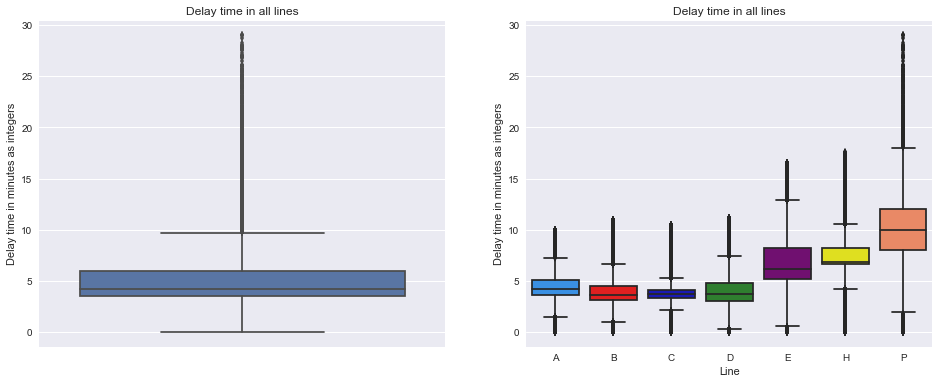

In [13]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1,2,1)
ax = sns.boxplot(subwayDataAgo.delayInt,orient = 'v')
ax.set_title('Delay time in all lines')
ax.set_ylabel('Delay time in minutes as integers')

ax2 = fig.add_subplot(1,2,2)
ax2 = sns.boxplot(subwayDataAgo.line,subwayDataAgo.delayInt,palette=lineColors)
ax2.set_title('Delay time in all lines')
ax2.set_ylabel('Delay time in minutes as integers')
ax2.set_xlabel('Line')

In [16]:
waitingTimeByLine

,count,mean,std,min,25%,50%,75%,max
line,,,,,,,,
A,281746,0 days 00:04:41.404381,0 days 00:01:22.247409,0 days 00:00:00,0 days 00:03:39,0 days 00:04:15,0 days 00:05:06,0 days 00:10:00
B,317142,0 days 00:03:58.802066,0 days 00:01:14.231633,0 days 00:00:00,0 days 00:03:06,0 days 00:03:39,0 days 00:04:30,0 days 00:11:00
C,337471,0 days 00:03:54.705642,0 days 00:01:13.363738,0 days 00:00:00,0 days 00:03:17,0 days 00:03:41,0 days 00:04:04,0 days 00:10:30
D,329334,0 days 00:04:00.224134,0 days 00:01:27.603852,0 days 00:00:00,0 days 00:03:00,0 days 00:03:45,0 days 00:04:47,0 days 00:11:06
E,193452,0 days 00:06:49.474267,0 days 00:02:19.143109,0 days 00:00:00,0 days 00:05:10,0 days 00:06:10,0 days 00:08:15,0 days 00:16:31
H,187217,0 days 00:07:12.912913,0 days 00:01:47.701505,0 days 00:00:00,0 days 00:06:36,0 days 00:06:50,0 days 00:08:12,0 days 00:17:36
P,54387,0 days 00:10:10.765017,0 days 00:02:54.809200,0 days 00:00:00,0 days 00:08:00,0 days 00:10:00,0 days 00:12:00,0 days 00:29:00


In [22]:
lines = subwayDataAgo.line.unique()
waitingTimeByLine = subwayDataAgo.delay.groupby(by=subwayDataAgo.line).describe()
for line in lines:
    print line,'median:',waitingTimeByLine['50%'][line],line,'mean:',waitingTimeByLine['mean'][line]

 A median: 0 days 00:04:15 A mean: 0 days 00:04:41.404381
B median: 0 days 00:03:39 B mean: 0 days 00:03:58.802066
C median: 0 days 00:03:41 C mean: 0 days 00:03:54.705642
D median: 0 days 00:03:45 D mean: 0 days 00:04:00.224134
E median: 0 days 00:06:10 E mean: 0 days 00:06:49.474267
H median: 0 days 00:06:50 H mean: 0 days 00:07:12.912913
P median: 0 days 00:10:00 P mean: 0 days 00:10:10.765017


In [24]:
subwayDataAgo.head()

,date,line,dayType,travelId,trainId,notDispach,notDispachDetails,amountCars,dispached,time,terminal,depart,delay,delayInt,month,departHour
460,2015-01-05,A,H,1,2,,,5,N,04:12:15,1,2015-01-05 04:12:15,NaT,NaN,NaN,NaN
461,2015-01-05,A,H,2,3,,,5,N,04:20:15,1,2015-01-05 04:20:15,NaT,NaN,NaN,NaN
462,2015-01-05,A,H,3,4,,,5,N,04:27:45,1,2015-01-05 04:27:45,NaT,NaN,NaN,NaN
463,2015-01-05,A,H,4,5,,,5,N,04:32:15,1,2015-01-05 04:32:15,NaT,NaN,NaN,NaN
464,2015-01-05,A,H,5,6,,,5,N,04:41:45,1,2015-01-05 04:41:45,NaT,NaN,NaN,NaN


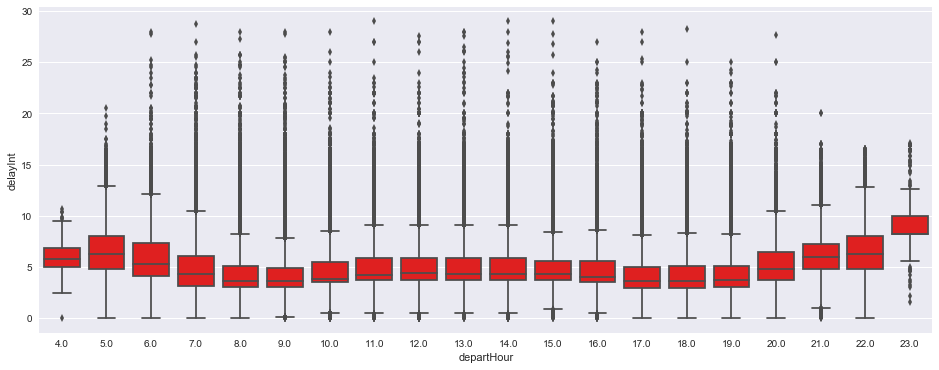

In [26]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1,1,1)
ax = sns.boxplot(subwayDataAgo.departHour,subwayDataAgo.delayInt,color=lineColors['B'])

In [62]:
def plotLineTimeSeries(line,dataset):
    fig = plt.figure(figsize=(16,6))
    plotId = 1
    color = lineColors[line] 
    for i in [1,2]:
        terminal = stationsNames[line][i]
        
        if line == 'P' and i == 2 :
            break
            
        #print terminal 
        plotMask = (dataset.line == line) & (dataset.terminal == i)
        #print sum(plotMask), len(plotMask)
        
           
        ax = fig.add_subplot(1,2,plotId)
        ax = sns.boxplot(dataset.departHour[plotMask],dataset.delayInt[plotMask],color=color)
        ax.set_xlabel('Hour')
        ax.set_ylabel('Delay (minutes)')
        ax.set_xticklabels(dataset.departHour[plotMask].unique(),rotation='vertical')

        ax.set_title('Line ' + line + ' - ' + terminal )
        fig.savefig('img/plotLine' + line + '.png')
        plotId += 1

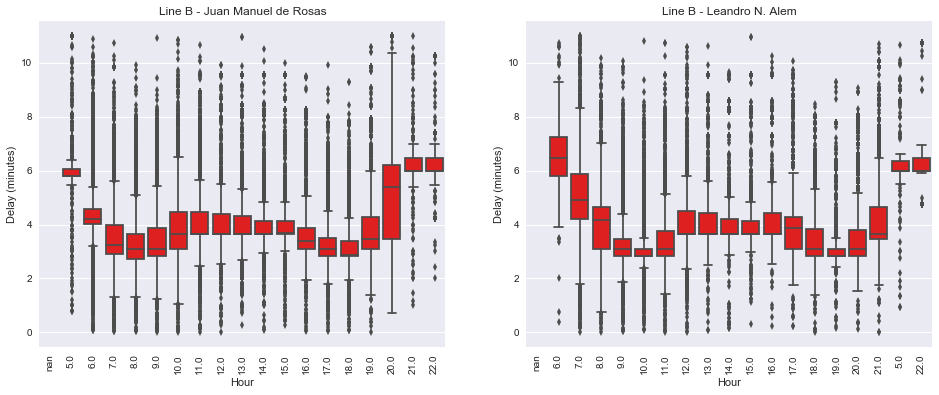

In [63]:
plotLineTimeSeries(line='B',dataset=subwayDataAgo)

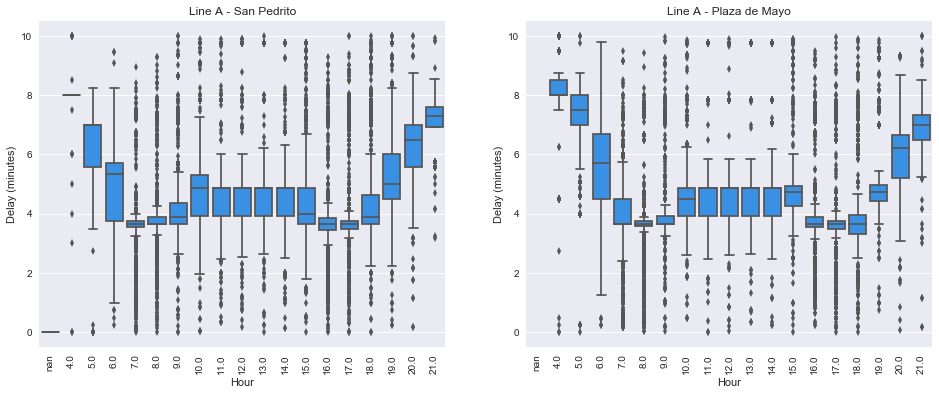

In [64]:
plotLineTimeSeries(line='A',dataset=subwayDataAgo)

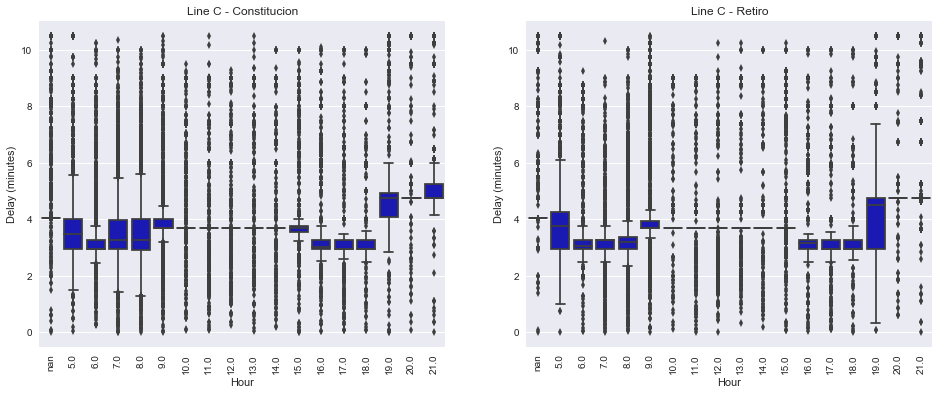

In [65]:
plotLineTimeSeries(line='C',dataset=subwayDataAgo)

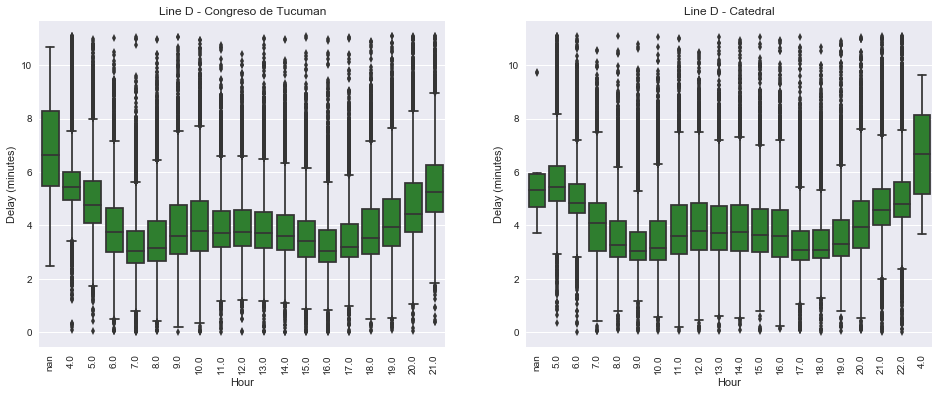

In [66]:
plotLineTimeSeries(line='D',dataset=subwayDataAgo)

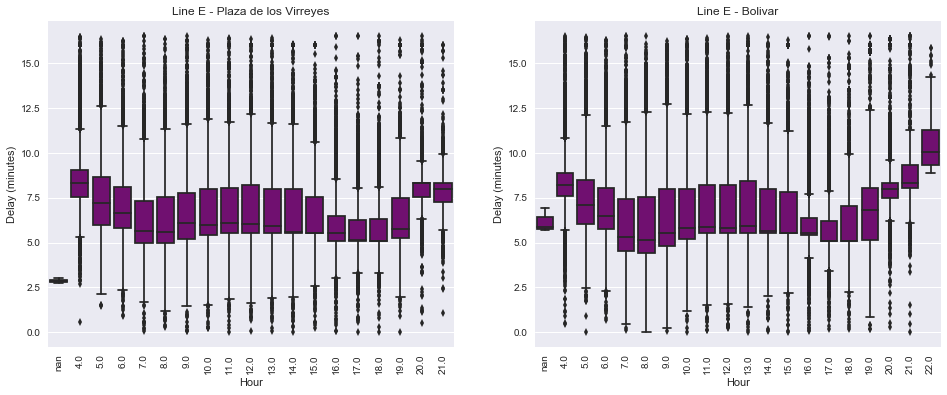

In [67]:
plotLineTimeSeries(line='E',dataset=subwayDataAgo)

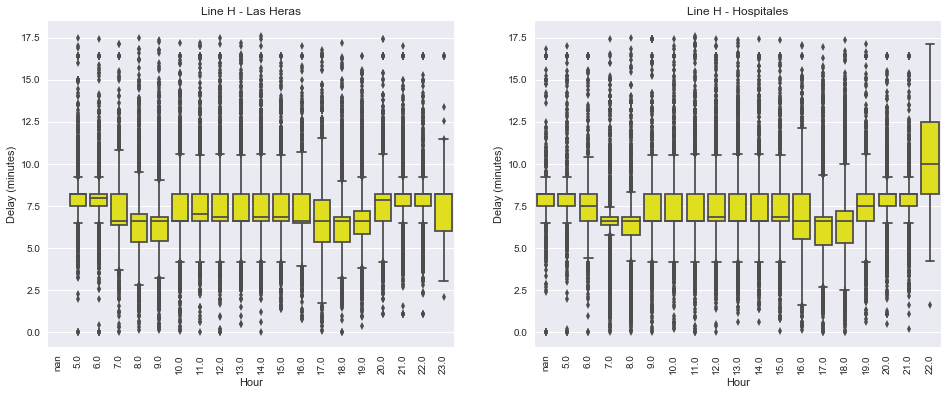

In [68]:
plotLineTimeSeries(line='H',dataset=subwayDataAgo)

In [40]:
subwayDataAgo.departHour.value_counts().values.min()

1986

In [47]:
subwayDataAgo.departHour.dropna().unique()

array([  4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,
        15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.])

In [57]:
def plotLineTimeSeries2(line,dataset,bootTraces = False):
    fig = plt.figure(figsize=(16,6))
    plotId = 1
    color = lineColors[line] 
    for i in [1,2]:
        terminal = stationsNames[line][i]
        
        if line == 'P' and i == 2 :
            break
            
        #print terminal 
        plotMask = (dataset.line == line) & (dataset.terminal == i)
        #print sum(plotMask), len(plotMask)
            
        waitingTime2 = dataset.loc[plotMask,:]
        
        n = waitingTime2.departHour.value_counts().values.min()

        baseParaMergear = waitingTime2.iloc[0:1,:].copy()


        for hora in waitingTime2.departHour.dropna().unique():
            
            insumo = waitingTime2.loc[waitingTime2.departHour==hora,:].sample(n=n).copy()
            #print mes
            baseParaMergear = pd.concat([baseParaMergear,insumo])

        baseParaMergear.index = range(baseParaMergear.shape[0])
        baseParaMergear.drop(0,axis=0,inplace=True)
        baseParaMergear['uniqueId'] = baseParaMergear.groupby(['departHour']).cumcount()
        baseParaMergear.index = range(baseParaMergear.shape[0])
        
        
        
        month2 = []
        iden = 1

        for i in range(baseParaMergear.shape[0]):
            if i==0:
                month2.append(iden)
                #print iden
            else:
                if baseParaMergear.departHour[i] == baseParaMergear.departHour[i-1]:
                    month2.append(iden)
                else:
                    iden += 1
                    month2.append(iden)
                    #print iden
        baseParaMergear['month2'] = month2
        
        
        
        ax = fig.add_subplot(1,2,plotId)
        if bootTraces:
            ax = sns.tsplot(time="month2", value="delayInt",unit="uniqueId", condition="line",data=baseParaMergear,
                        color=color, err_style="boot_traces", n_boot=500)
        else:
            ax = sns.tsplot(time="month2", value="delayInt",unit="uniqueId", condition="line",data=baseParaMergear,
        ci=[50,75,95], color=color,estimator=np.median)
        

        ax.set_xlabel('Hour')
        ax.set_ylabel('Delay (minutes)')
        ax.set_xticklabels( waitingTime2.departHour.dropna().unique(),rotation='vertical')

        ax.set_title('Line ' + line + ' - ' + terminal)
        #fig.savefig('../img/plotLine' + line + '.png')
        plotId += 1

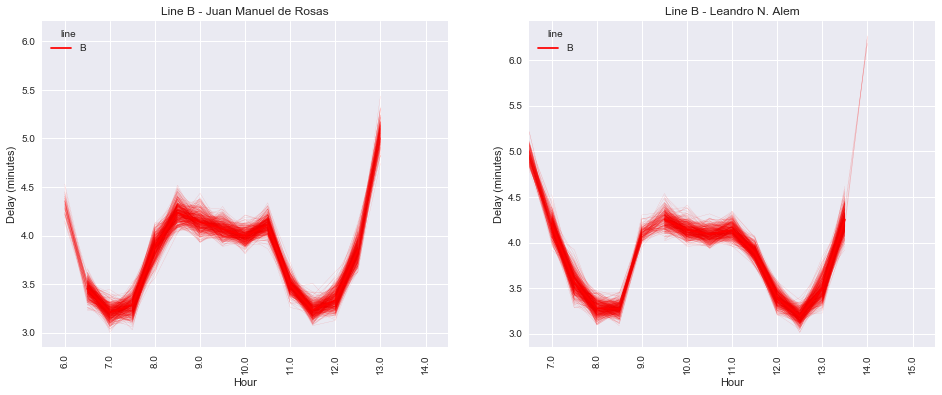

In [58]:
plotLineTimeSeries2(line='B',dataset=subwayDataAgo,bootTraces = True)

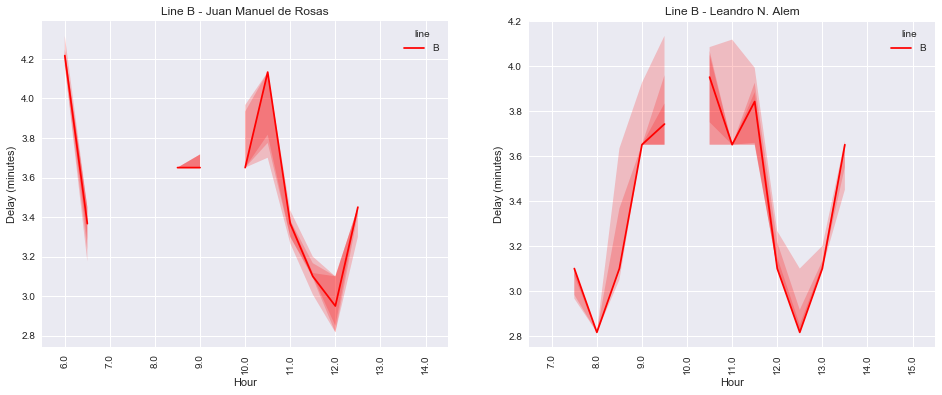

In [59]:
plotLineTimeSeries2(line='B',dataset=subwayDataAgo,bootTraces = False)